In [309]:
import underworld as uw
import matplotlib as mpl
from matplotlib.figure import Figure
import matplotlib.pyplot as pyplot
import numpy as np
import math
import h5py
import glob
import UWGeodynamics as GEO
#from MechanicalProperties import PlateProperties
from pathlib import Path
import sys
import underworld.function as fn
#import glucifer
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.offsetbox import AnchoredText

In [310]:
def getColoursfromMap(cmapKey,NumColours):
    cmap = plt.get_cmap(cmapKey)
    norm = mcolors.Normalize(vmin=1.5, vmax=NumColours)
    #Base array to calculate the colors
    seedColors=np.arange(0,NumColours,1) #Here is the start color
    colours=cmap(norm(seedColors))
    return colours

def genStdColorArray(Thicknesses,colors,colorflip):
    iColor=0
    limitThick=colorflip[1]
    plotCounter=0
    #Get Colors and put them into an array
    ColorsS=[]
    colorC=0
    for j in colors:
        ColorsS.append(getColoursfromMap(colors[colorC],len(Thicknesses)))
        colorC=colorC+1
    counter=0
    #array which will contain colors to return    
    FinalColours=[]
    
    for i in Thicknesses:
        #Color changes
        if colorflip[0]==True:
            if limitThick> i:
                Colors=ColorsS[0]
            elif limitThick<=i:
                Colors=ColorsS[1]    
            else:
                Colors=ColorsS[0]     
        color=Colors[counter]
        FinalColours.append(color)
        counter=counter+1
    return FinalColours

def velocitiesLoader(DataDir,thickness,typePlot,fileSeed):
    fileName=DataDir+fileSeed+"{0}.txt".format(str(thickness))
    Data = np.genfromtxt(fileName, dtype=float,skip_footer=1)
    v_sp=Data[:,1]
    v_op=-Data[:,3]
    v_t=-(Data[:,2]+Data[:,3])
    v_t2=-Data[:,4]
    #Independent from reference frame
    Vc=v_op+v_sp
    Vs=v_t+v_sp
    
    if typePlot=="subduction_velocity":
        t,vel=Data[:,0],v_sp
    elif typePlot=="Trench_retreat_vel":
        t,vel=Data[:,0],v_t
    elif typePlot=="OP_retreat_vel":
        t,vel=Data[:,0],v_op
    elif typePlot=="Arc_retreat_vel":
        t,vel=Data[:,0],v_t2
    elif typePlot=="OPDefRate": #overriding plate deformation rate
        t,vel=Data[:,0],v_t-v_op
    elif typePlot=="Sub_vel": #Actual subduction velocity?
        t,vel=Data[:,0],v_t+v_sp
    elif typePlot=="Conver_vel":
        t,vel=Data[:,0], v_sp+v_op
    return t,vel



In [379]:

def plotSubploterVelocityAlltxt(figsize,Thicknesses,Colors,plotsIndexes,typePlots,names):
    mpl.rcParams['pdf.fonttype'] = 42
    mpl.rcParams['ps.fonttype'] = 42
    Nplots=len(typePlots)
    fig, axs = pyplot.subplots(len(plotsIndexes),figsize=figsize,sharex=True)
    #Loop for subplots 
    plotCounter=0
    for dataIndex in plotsIndexes:
        counter=0
        Max=0
        Min=0
        #Loop for iterating thicknesses
        
        for i in Thicknesses:
            seed=axs[plotCounter]
            plotType=typePlots[dataIndex]
            #Load velocity and time data from file - THIS DIRECTORY MUST BE CHANGED TO THE ONE OF YOUR LOCAL SERVER/LOCAL MACHINE
            t,vel=velocitiesLoader('/home/jovyan/user_data/Re-submission/Dynamics-of-Arc-Continent-Collision/Kinematics_data2/',i,plotType,"platesVelocities_")
            #t,vel=getTypeVelocity(plotType,Time_array,counter,SPVel,cratVel,OPVel,arcVel)
            #Check for 0km curve
            if i==0:
                colour='black'
            else:
                colour=Colors[counter]
            seed.plot(t,vel,label='{0} Km'.format((eval(str(i)))),linewidth=0.6,color=colour)
            
       
            
            seed.set_ylabel("Velocity (cm/yr)",labelpad=2,fontsize=8)
            seed.legend(fontsize=6,fancybox=True)############
            seed.tick_params(axis = 'both', which = 'major', labelsize =8) 
            seed.set_xlim(0,45)
            #seed.yaxis.set_major_locator(mpl.ticker.LinearLocator(5))
            Max=max(vel)
            Min=min(vel)
            if plotCounter==0:
                seed.set_ylim((1.52*Min),Max*1.98)
            
            elif plotCounter==1:
                seed.set_ylim((1.52*Min),Max*1.98)
            if plotType=="OPDefRate":
                seed.set_ylabel(r"$V_{OPD}$"+" (cm/yr)",labelpad=2,fontsize=8)
                #pyplot.yscale('symlog')
                seed.set_ylim((1.22*Min),Max*2.98)
                a=1
            elif plotType=="Sub_vel":
                seed.set_ylabel(r"$V_{S}$"+" (cm/yr)",labelpad=2,fontsize=8)
            #Title from loadaed file
            anchored_title=AnchoredText(names[dataIndex],loc='upper center',pad=0.5,borderpad=0.5,frameon=False,prop={'fontweight': 'ultralight', 'size': 8})
            seed.add_artist(anchored_title)
            #fontdict={'weight': 'normal', 'size': 8}
            counter=counter+1
           
        #counter=counter-1
        seed.set_xlabel("Time (Ma)",labelpad=2,fontsize=8)
        if plotType=="subduction_velocity":
            seed.axhline(y=0, xmin=0, xmax=max(t)+max(t)/6.,color='black',linestyle='--',linewidth=0.7,alpha=0.4)
            seed.axvline(x=16,ymin=-10,ymax=10,linestyle='--',color='black',linewidth=0.7,alpha=0.4)
            seed.axvline(x=22.5,ymin=-10,ymax=10,linestyle='--',color='black',linewidth=0.7,alpha=0.4)
            seed.axvline(x=34,ymin=-10,ymax=10,linestyle='--',color='black',linewidth=0.7,alpha=0.4)
            
        if plotType=="Trench_retreat_vel":
            seed.axhline(y=0, xmin=0, xmax=max(t)+max(t)/6.,color='black',linestyle='--',linewidth=0.7,alpha=0.4)
            seed.axvline(x=16.,ymin=-10,ymax=10,linestyle='--',color='black',linewidth=0.7,alpha=0.4)
            seed.axvline(x=22.5,ymin=-10,ymax=10,linestyle='--',color='black',linewidth=0.7,alpha=0.4)
            seed.axvline(x=34.,ymin=-10,ymax=10,linestyle='--',color='black',linewidth=0.7,alpha=0.4)

        if plotType=="OP_retreat_vel":
            seed.axhline(y=0, xmin=0, xmax=max(t)+max(t)/6.,color='black',linestyle='--',linewidth=0.7,alpha=0.4)
            seed.axvline(x=16,ymin=-10,ymax=10,linestyle='--',color='black',linewidth=0.7,alpha=0.4)
            seed.axvline(x=22.5,ymin=-10,ymax=10,linestyle='--',color='black',linewidth=0.7,alpha=0.4)
            seed.axvline(x=34.,ymin=-10,ymax=10,linestyle='--',color='black',linewidth=0.7,alpha=0.4)
            
        #if plotType=="Arc_retreat_vel":
        seed.axhline(y=0, xmin=0, xmax=max(t)+max(t)/6.,color='black',linestyle='--',linewidth=0.7,alpha=0.4)
        seed.axvline(x=16,ymin=-10,ymax=10,linestyle='--',color='black',linewidth=0.7,alpha=0.4)
        seed.axvline(x=22.5,ymin=-10,ymax=10,linestyle='--',color='black',linewidth=0.7,alpha=0.4)
        seed.axvline(x=34.,ymin=-10,ymax=10,linestyle='--',color='black',linewidth=0.7,alpha=0.4)
            
        adjustX=(0+45)/9.
        #Arrange ticks Array
        arrangeTicksX=np.arange(0,46,adjustX)
        #Ticks Change
        seed.xaxis.set_ticks(arrangeTicksX)
            
        plotCounter=plotCounter+1
    
    fig.tight_layout(pad=1,h_pad=0.08,w_pad=0.0)
    pyplot.subplots_adjust(wspace=0, hspace=0)
    %matplotlib
    return fig


In [371]:
saveDir='/home/jovyan/user_data/Re-submission/Dynamics-of-Arc-Continent-Collision/Raw_PDFs/'

## Reference-frame dependent velocities: 

1. Vsp= Subducting plate velocity

2. Vt= trench velocity

3. Vop= Overriding plate velocity

In [382]:
typePlots=["subduction_velocity","Trench_retreat_vel","OP_retreat_vel","Arc_retreat_vel"]
names=["SP velocity vs Time","Trench-advance velocity vs Time","OP retreat velocity vs Time","Arc retreat velocity vs Time"]
#Model parameters and directories
dimensions = ([-1800.,-800.],[1800.,0.])
outres = (1500,300) #Output image resolution
xRes,yRes = 296,160 #Grid/mesh resolution
seed1="outputs_MechanicalTransference_BenchmarkFinal_"
seed2="kmArc_80Ma_DruckerPrager_WLM"
#gravity=9.81*u.meter/u.second**2
#Uniform Color scale for all plots of GPE - deltaStress
ColorsPlots=genStdColorArray([0,15,16,17,18,19,20,21,22,23,24,25,32,33,34,35],["Blues_r","Reds"],[True, 32.]) #["Blues_r","Reds"]
#15,20,23,25,30,32,33,35

Using matplotlib backend: agg


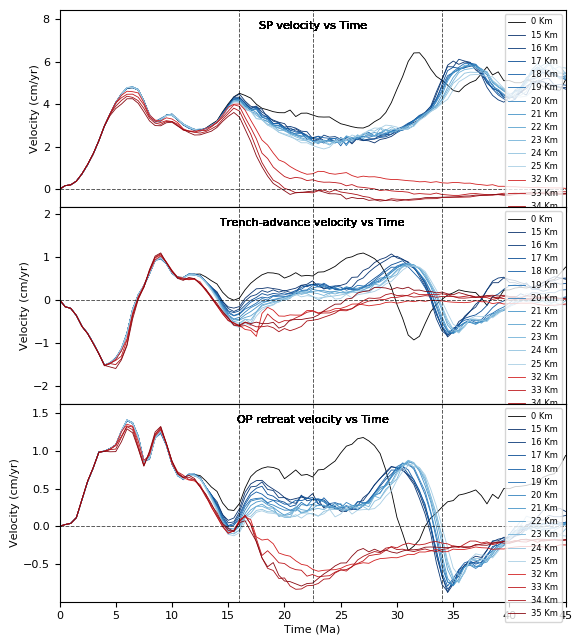

In [383]:
fig=plotSubploterVelocityAlltxt((15/2.54, 18/2.54),[0,15,16,17,18,19,20,21,22,23,24,25,32,33,34,35],ColorsPlots,[0,1,2],typePlots,names) #for 3 use (15/2.54, 18/2.54)
fig

In [374]:
fig.savefig(saveDir+'Fig_SX_Kinematics.pdf')

## Reference-frame indedependent velocities: 

1. Vc = Subduction velocity

2. VODP= Overriding plate defomation rate (positive is extension and negative compression)


In [375]:
typePlots=["OPDefRate","Sub_vel","Conver_vel","Arc_retreat_vel"]
names=["OP deformation rate","Subduction velocity","Convergence velocity","Arc retreat velocity vs Time"]
#Model parameters and directories
dimensions = ([-1800.,-800.],[1800.,0.])
outres = (1500,300) #Output image resolution
xRes,yRes = 296,160 #Grid/mesh resolution
seed1="outputs_MechanicalTransference_BenchmarkFinal_"
seed2="kmArc_80Ma_DruckerPrager_WLM"
#gravity=9.81*u.meter/u.second**2
#Uniform Color scale for all plots of GPE - deltaStress
ColorsPlots=genStdColorArray([0,15,16,17,18,19,20,21,22,23,24,25,32,33,34,35],["Blues_r","Reds"],[True, 32.]) #["Blues_r","Reds"]
#15,20,23,25,30,32,33,35
#0,16,20,25,28,32,34,35

Using matplotlib backend: agg


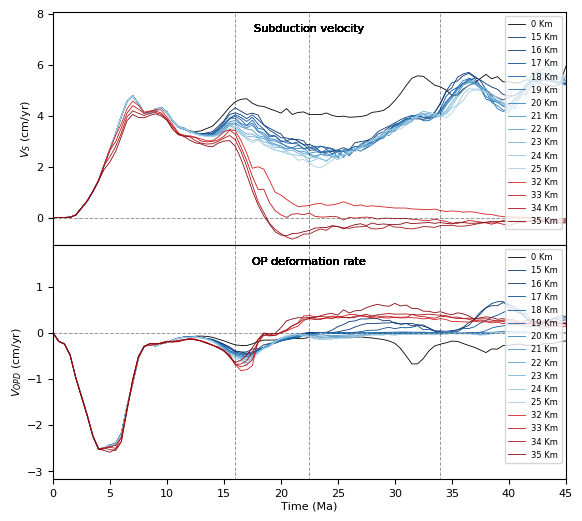

In [380]:
fig=plotSubploterVelocityAlltxt((15/2.54, 14/2.54),[0,15,16,17,18,19,20,21,22,23,24,25,32,33,34,35],ColorsPlots,[1,0],typePlots,names) #for 3 use (15/2.54, 18/2.54)
fig

In [381]:
fig.savefig(saveDir+'Fig_6_raw_legend.pdf')
#fig.savefig(saveDir+'Fig_6_raw.pdf')